In [1]:
from osgeo import gdal, osr
import os, struct
import numpy as np
import subprocess
import geopandas as gpd
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray

In [2]:
processing_gdal_dir = '/shared/data/building-emissions/data/processing_files_gdal/'

### functions


In [3]:

def change_crs(input_file, output_file,crs='ESRI:54009'):
    df = gpd.read_file(input_file)
    nds = df.to_crs(crs)
    nds.to_file(output_file, driver="GeoJSON")

class Gtif:
    def __init__(self,path,mode='load',shape=None, datatype=gdal.GDT_Float32):
        if mode == 'load':
            self.path = path
            self.file = gdal.Open(self.path)
        
        elif mode == 'new':
            driver = gdal.GetDriverByName("GTiff")
            self.file = driver.Create(path, 
                       xsize=shape[0], 
                       ysize=shape[1],
                       bands=1, 
                       eType=datatype,
                       options = [ 'COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256' ]
            )
        self.band = self.file.GetRasterBand(1)
        self.x = self.band.XSize
        self.y = self.band.YSize
        # self.bandtypename = gdal.GetDataTypeName(self.band.DataType)
        self.bandtype = self.band.DataType
        
        # print("rows = %d columns = %d" % (self.x, self.y))
        # print("Band Type = ", self.bandtype)
        
    def close(self):
        self.file = None
    
    def get_projection(self):
        return self.file.GetProjection()
    
    def get_geotransform(self):
        return self.file.GetGeoTransform()
    
    def set_projection(self,projection):
        srs = osr.SpatialReference(wkt = projection)
        self.file.SetProjection(srs.ExportToWkt())
    
    def set_geotransform(self,geotransform):
        self.file.SetGeoTransform(geotransform)
        
    def write_data(self,raster):
        self.band.WriteArray( raster )
        
# Code to losslessly compress files
def compress(src,dst):
    gdal.Translate(dst,src,creationOptions=['COMPRESS=DEFLATE', 'PREDICTOR=2' ,'TILED=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256'])

# Code to multiply single bands of files into one set of files
def multiply_single_band_files(file_list,out_file):
    # Example command:
    # gdal_calc.py -A co2_total_20yr.tif -B temp_test.tif --calc="A*B" --outfile=result.tif
    if len(file_list) == 2:
        input_commands = ['gdal_calc.py','-A', file_list[0], '-B', file_list[1], '--calc="A*B"', '--outfile=' + out_file]
    if len(file_list) == 3:
        input_commands = ['gdal_calc.py','-A', file_list[0], '-B', file_list[1], '-C', file_list[2], '--calc="A*B*C"', '--outfile=' + out_file]
    subprocess.run(input_commands)

# Create a raster layer from a vector dataset and grid of the world
def rasterize(attribute,layername,vector_file_path,raster_grid_path):
    # Example command:
    # gdal_rasterize -b 1 -a "labelrank" -l world world.json basegrid.tif
    input_commands = ['gdal_rasterize','-b','1','-a',attribute,'-l',layername, vector_file_path, raster_grid_path]
    subprocess.run(input_commands)

def create_empty_grid(source_path,dest_path,const):
    source = Gtif(source_path)
    projection = source.get_projection()
    geotransform = source.get_geotransform()
    x = source.x
    y = source.y
    dtype = source.bandtype
    source.close() # Close the file
    
    dest_data = Gtif(dest_path,
                    mode='new',
                    shape=(x,y), 
                    datatype=dtype
    )
    dest_data.set_projection(projection)
    dest_data.set_geotransform(geotransform)
    raster = const*np.ones((y,x))
    dest_data.write_data(raster)
    dest_data.close()
    
def get_info(file):
    info = gdal.Info(file)
    print(info)

In [4]:
# simplify polygons with .simplfy by 50 meters with multiprocessing
def simplify_geom_helper(gdf, tolerance, results):
    gdf['sim_geometry'] = gdf['geometry'].apply(lambda geom: geom.simplify(tolerance))
    results.append(gdf)
    pass
def simplify_geom(gdf, tolerance):
    # use multiprocessing to speed up
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes= num_cores)
    chunk_size = len(gdf)//num_cores + 1
    results = multiprocessing.Manager().list()
    for i in range(0, len(gdf), chunk_size):
        pool.apply_async(simplify_geom_helper, args=(gdf.iloc[i:i+chunk_size], tolerance, results))
    pool.close()
    pool.join()
    new_gdf = gpd.GeoDataFrame(pd.concat(results, ignore_index=True))
    return new_gdf

## My code

### Emission Factor: Change CRS and Simplify polygons of EF    
1 mins
1. Add EF with unit **mton/J**
2. Change CRS to **ESRI:54009**
3. **Simplify the geometry by 50 meter**: 1 mins
4. save as a json file

In [10]:
# Modify EF Unit to be in mt/J
ef_path = '/shared/data/building-emissions/data/emissionsfactors/global_emissionsfactors_nobiofuel.parquet'
ef = gpd.read_parquet(ef_path)
ef["Residential_Methane_mtJ"] = ef["Residential_Methane"] * (10**(-9))
ef["Residential_CO2_mtJ"] = ef["Residential_CO2"] * (10**(-9))
ef["Residential_N2O_mtJ"] = ef["Residential_N2O"] * (10**(-9))
ef["Commercial_Methane_mtJ"] = ef["Commercial_Methane"] * (10**(-9))
ef["Commercial_CO2_mtJ"] = ef["Commercial_CO2"] * (10**(-9))
ef["Commercial_N2O_mtJ"] = ef["Commercial_N2O"] * (10**(-9))
# Modify CRS to be in ESRI:54009
ef = ef.to_crs('ESRI:54009')


In [19]:
# simplify polygons by 50 meters
new_ef = simplify_geom(ef, 50)
# drop geometry column and rename sim_geometry to geometry
new_ef = new_ef.drop(columns = ['geometry']).rename(columns = {'sim_geometry':'geometry'})
# set geometry column to geometry
new_ef = new_ef.set_geometry('geometry')

# save to json
simplified_ef_path = os.path.join(processing_gdal_dir, 'ef_simplified.json')
new_ef.to_file(simplified_ef_path, index = False, driver = 'GeoJSON')

### EUI: Change CRS, Simplify polygons of EUI, Split eui to 4 level, (level 4 is the finest)
1. Modify Unit to megajuels
2. Modify CRS: 1 mins
3. Simplify polygons: 3mins
4. Split into 4 level and save files: 1 misn


In [16]:
# read chunked eui files and combine into one dataframe
eui_0 = gpd.read_parquet('/shared/data/building-emissions/data/energyuseintensities/eui_chunks/eui_0.parquet')
eui_1 = gpd.read_parquet('/shared/data/building-emissions/data/energyuseintensities/eui_chunks/eui_1.parquet')
eui_2 = gpd.read_parquet('/shared/data/building-emissions/data/energyuseintensities/eui_chunks/eui_2.parquet')
eui = gpd.GeoDataFrame(pd.concat([eui_0, eui_1, eui_2], ignore_index=True))
# modify Unit to be in MJ
eui['Non-residential_EUI_mj'] = eui['Non-residential EUI (kwh)']*3.6
eui['Residential_EUI_mj'] = eui['Residential EUI (kwh)']*3.6
# modify CRS to be in ESRI:54009
eui = eui.to_crs('ESRI:54009')

In [21]:

# simplify eui pologons
new_eui = simplify_geom(eui, 50)
# drop geometry column and rename sim_geometry to geometry
new_eui = new_eui.drop(columns = ['geometry']).rename(columns = {'sim_geometry':'geometry'})
# set geometry column to geometry
new_eui = new_eui.set_geometry('geometry')

# save to json
simplified_eui_path = os.path.join(processing_gdal_dir, 'eui_simplified.json')
new_eui.to_file(simplified_eui_path, index = False, driver = 'GeoJSON')

In [24]:
# subset eui to different levels
    # level 4: gid2 is not null
    # level 3: gid1 is not null
    # level 2: gid0 is not null: country level
    # level 1: continent level

new_eui_level4 = new_eui[new_eui['level'] == 2].copy()
new_eui_level3 = new_eui[new_eui['level'] == 1].copy()
new_eui_level2 = new_eui[new_eui['level'] == 0 ].copy()
new_eui_level1 = new_eui[new_eui['level'] == -1].copy()
# save eui
new_eui_level4.to_file('/shared/data/building-emissions/data/processing_files_gdal/eui_level4_simplified.json', driver="GeoJSON")
new_eui_level3.to_file('/shared/data/building-emissions/data/processing_files_gdal/eui_level3_simplified.json', driver="GeoJSON")
new_eui_level2.to_file('/shared/data/building-emissions/data/processing_files_gdal/eui_level2_simplified.json', driver="GeoJSON")
new_eui_level1.to_file('/shared/data/building-emissions/data/processing_files_gdal/eui_level1_simplified.json', driver="GeoJSON")

### Rasterize
size = (18000, 36082)
1. Rasterize 4 levels EUIs: 7 mins(without compression)
2. Rasterize EF:13 mins(without compression), takes longer time because of Float 64

In [7]:
# gdal_rasterize -a Residential_EUI_mj -l eui_level2_simplified  ./eui_level2_simplified.json ./eui_res_level2.tif
def rasterize(attribute,layername,vector_file_path,raster_grid_path):
    # Example command:
    # gdal_rasterize -b 1 -a "labelrank" -l world world.json basegrid.tif
    input_commands = ['gdal_rasterize','-b','1','-a',attribute,'-l',layername, vector_file_path, raster_grid_path]
    subprocess.run(input_commands)



In [9]:
# 7 mins(without compression)
eui_path = processing_gdal_dir
empty_grid_path = os.path.join(processing_gdal_dir, 'ghs.tif')
eui_rasterize_list = [['4','Non-residential_EUI_mj', 'eui_nres_level4'], ['4', 'Residential_EUI_mj', 'eui_res_level4'], \
                    ['3','Non-residential_EUI_mj', 'eui_nres_level3'], ['3', 'Residential_EUI_mj', 'eui_res_level3'], \
                    ['2','Non-residential_EUI_mj', 'eui_nres_level2'], ['2', 'Residential_EUI_mj', 'eui_res_level2'], \
                    ['1','Non-residential_EUI_mj', 'eui_nres_level1'], ['1', 'Residential_EUI_mj', 'eui_res_level1']]
# EUI
for i in eui_rasterize_list:
    eui_path_source = os.path.join(eui_path, 'eui_level'+i[0]+'_simplified.json')
    eui_path_dest = os.path.join(eui_path, i[2]+'.tif')
    # create empty raster
    create_empty_grid(empty_grid_path, os.path.join(eui_path, i[2]+'.tif'), 0)
    rasterize(i[1],'eui_level'+i[0]+'_simplified',eui_path_source,eui_path_dest)
    # compress(eui_path_dest,os.path.join(eui_path, i[2]+'_compressed.tif'))


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
# 11 mins without compression
ef_rasterize_list = [['Residential_Methane_mtJ', 'ef_res_methane.tif'], ['Residential_CO2_mtJ', 'ef_res_co2.tif'], \
                    ['Residential_N2O_mtJ', 'ef_res_n2o.tif'], ['Commercial_Methane_mtJ', 'ef_nres_methane.tif'], \
                    ['Commercial_CO2_mtJ', 'ef_nres_co2.tif'], ['Commercial_N2O_mtJ', 'ef_nres_n2o.tif']]

# EF
layername_ef = 'ef_simplified'
ef_path_source = os.path.join(processing_gdal_dir, 'ef_simplified.json')
empty_grid_path = os.path.join(processing_gdal_dir, 'ghs.tif')
empty_ef_grid_path = os.path.join(processing_gdal_dir, 'ef_empty.tif')  # create empty raster
create_empty_grid(empty_grid_path, empty_ef_grid_path, 0)

for i in ef_rasterize_list:
    attribute = i[0]
    ef_path_dest = processing_gdal_dir + i[1]
    # make it float 64 or it will be int 32 if using the empty grid from ghs.tif
    subprocess.run(f'gdal_translate -ot Float64 {empty_ef_grid_path} {ef_path_dest}', shell=True, cwd = processing_gdal_dir)
    rasterize(attribute, layername_ef, ef_path_source, ef_path_dest)


Input file size is 36082, 18000
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 36082, 18000
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 36082, 18000
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 36082, 18000
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 36082, 18000
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 36082, 18000
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Get Residential building area file: 1 mins

In [13]:
empty_grid_path = os.path.join(processing_gdal_dir, 'ghs.tif')
res_area_path = os.path.join(processing_gdal_dir, 'res_area.tif')
create_empty_grid(empty_grid_path, res_area_path, 0)
subprocess.run('gdal_calc.py -A ./total_area.tif -B ./nres_area.tif --calc="A-B" --outfile=res_area.tif', shell=True, cwd = processing_gdal_dir)

0...10...20...30...40...50...60...70...80...90...100 - done.


CompletedProcess(args='gdal_calc.py -A ./total_area.tif -B ./nres_area.tif --calc="A-B" --outfile=res_area.tif', returncode=0)

### Getting the finest EUI
5 mins

In [17]:
# Residential : 3 mins

create_empty_grid(os.path.join(processing_gdal_dir, 'ghs.tif'), os.path.join(processing_gdal_dir, 'zero_grid.tif'), 0)
resEUI_level_list = ['eui_res_level4', 'eui_res_level3', 'eui_res_level2', 'eui_res_level1']
for eui_level in resEUI_level_list:
    create_empty_grid(os.path.join(processing_gdal_dir, 'ghs.tif'), os.path.join(processing_gdal_dir, eui_level+'_fine.tif'), 0)

resEUI_finest_list = ['gdal_calc.py -A zero_grid.tif -B eui_res_level4.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_res_level4_fine.tif',\
    'gdal_calc.py -A eui_res_level4_fine.tif -B eui_res_level3.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_res_level3_fine.tif', \
    'gdal_calc.py -A eui_res_level3_fine.tif -B eui_res_level2.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_res_level2_fine.tif',\
    'gdal_calc.py -A eui_res_level2_fine.tif -B eui_res_level1.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_res_level1_fine.tif']
for command in resEUI_finest_list:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:

create_empty_grid(os.path.join(processing_gdal_dir, 'ghs.tif'), os.path.join(processing_gdal_dir, 'zero_grid.tif'), 0)
nresEUI_level_list = ['eui_nres_level4', 'eui_nres_level3', 'eui_nres_level2', 'eui_nres_level1']
for eui_level in nresEUI_level_list:
    create_empty_grid(os.path.join(processing_gdal_dir, 'ghs.tif'), os.path.join(processing_gdal_dir, eui_level+'_fine.tif'), 0)

nresEUI_finest_list = ['gdal_calc.py -A zero_grid.tif -B eui_nres_level4.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_nres_level4_fine.tif',\
    'gdal_calc.py -A eui_nres_level4_fine.tif -B eui_nres_level3.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_nres_level3_fine.tif', \
    'gdal_calc.py -A eui_nres_level3_fine.tif -B eui_nres_level2.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_nres_level2_fine.tif',\
    'gdal_calc.py -A eui_nres_level2_fine.tif -B eui_nres_level1.tif --calc="B*(A==0) + A*(A!=0)" --outfile=eui_nres_level1_fine.tif']

for command in nresEUI_finest_list:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [19]:
# Final Fine command 
rename_finest_command = ['mv eui_nres_level1_fine.tif eui_nres_finest.tif', 'mv eui_res_level1_fine.tif eui_res_finest.tif']
for command in rename_finest_command:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)


#### EUI*AREA
2 mins

In [21]:
### EUI*area
# create empty eui_area grid
create_empty_grid(os.path.join(processing_gdal_dir, 'ghs.tif'), os.path.join(processing_gdal_dir, 'eui_area_res.tif'), 0)
create_empty_grid(os.path.join(processing_gdal_dir, 'ghs.tif'), os.path.join(processing_gdal_dir, 'eui_area_nres.tif'), 0)

eui_area_commands = ['gdal_calc.py -A ./res_area.tif -B ./eui_res_finest.tif  --calc="A*B" --outfile=eui_area_res.tif', \
    'gdal_calc.py -A ./nres_area.tif  -B ./eui_nres_finest.tif --calc="A*B"  --outfile=eui_area_nres.tif']
for command in eui_area_commands:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


#### EUI*AREA * EF
12 mins

In [25]:
# create empty emission grid
# ghs_grid_path = os.path.join(processing_gdal_dir, 'ghs.tif')
# create_empty_grid(ghs_grid_path, os.path.join(processing_gdal_dir, 'res_co2.tif'), 0)
# create_empty_grid(ghs_grid_path, os.path.join(processing_gdal_dir, 'res_methane.tif'), 0)
# create_empty_grid(ghs_grid_path, os.path.join(processing_gdal_dir, 'res_n2o.tif'), 0)
# create_empty_grid(ghs_grid_path, os.path.join(processing_gdal_dir, 'nres_co2.tif'), 0)
# create_empty_grid(ghs_grid_path, os.path.join(processing_gdal_dir, 'nres_methane.tif'), 0)
# create_empty_grid(ghs_grid_path, os.path.join(processing_gdal_dir, 'nres_n2o.tif'), 0)


emission_commands = [\
    'gdal_calc.py -A eui_area_res.tif -B ef_res_co2.tif --calc="A*B" --outfile=res_co2.tif', \
    'gdal_calc.py -A eui_area_res.tif -B ef_res_methane.tif --calc="A*B" --outfile=res_methane.tif', \
    'gdal_calc.py -A eui_area_res.tif -B ef_res_n2o.tif --calc="A*B" --outfile=res_n2o.tif', \
    'gdal_calc.py -A eui_area_nres.tif -B ef_nres_co2.tif --calc="A*B" --outfile=nres_co2.tif', \
    'gdal_calc.py -A eui_area_nres.tif -B ef_nres_methane.tif --calc="A*B" --outfile=nres_methane.tif', \
    'gdal_calc.py -A eui_area_nres.tif -B ef_nres_n2o.tif --calc="A*B" --outfile=nres_n2o.tif']
for command in emission_commands:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)



0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


#### get total emission by adding res + nres: 11 mins

In [33]:
total_emission_commands = [\
    'gdal_calc.py -A res_co2.tif -B nres_co2.tif --calc="A+B" --outfile=total_co2.tif', \
    'gdal_calc.py -A res_methane.tif -B nres_methane.tif --calc="A+B" --outfile=total_methane.tif', \
    'gdal_calc.py -A res_n2o.tif -B nres_n2o.tif --calc="A+B" --outfile=totla_n2o.tif']
for command in total_emission_commands:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)



0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
# calculate co2 equivalnt
# res_co2_grid + 82.5*res_methane_grid + 273*res_n2o_grid
# nres_co2_grid + 29.8*nres_methane_grid + 273*nres_n2o_grid
co2_equivalnt_commands = [\
    'gdal_calc.py -A res_co2.tif -B res_methane.tif -C res_n2o.tif --calc="A+82.5*B+273*C" --outfile=co2eq_res.tif', \
    'gdal_calc.py -A nres_co2.tif -B nres_methane.tif -C nres_n2o.tif --calc="A+29.8*B+273*C" --outfile=co2eq_nres.tif']
for command in co2_equivalnt_commands:
    subprocess.run(command, shell=True, cwd = processing_gdal_dir)



0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Compresssion

In [36]:
# compress all file: 13 mins
emission_files = ['res_co2.tif', 'res_methane.tif', 'res_n2o.tif', \
                'nres_co2.tif', 'nres_methane.tif', 'nres_n2o.tif', \
                    'total_co2.tif', 'total_methane.tif', 'totla_n2o.tif',\
                        'co2eq_res.tif', 'co2eq_nres.tif']
emission_files = ['co2eq_res.tif', 'co2eq_nres.tif']
p = processing_gdal_dir
for file in emission_files:
    compress(p+'/'+file, p+'/'+file[:-4]+'_compressed.tif')



### Some checks

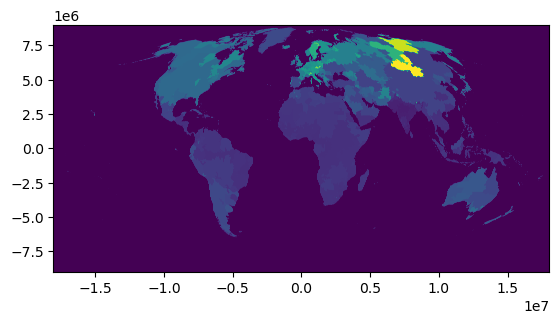

<Axes: >

In [20]:
img = rasterio.open('/shared/data/building-emissions/data/processing_files_gdal/eui_res_finest.tif')
show(img)

In [ ]:
# code for checking 
rds = rioxarray.open_rasterio(os.path.join(processing_gdal_dir,'res_co2_compressed.tif'))
rds.name = "data"
df = rds.squeeze().to_dataframe().reset_index()
# ignore no data value
df_ = df[df['data']!= df.max().max()]
# # 3781036316.995747 # previous approach
## 3781693743.7959847 # gdal

df_.data.sum()

### Check by plot

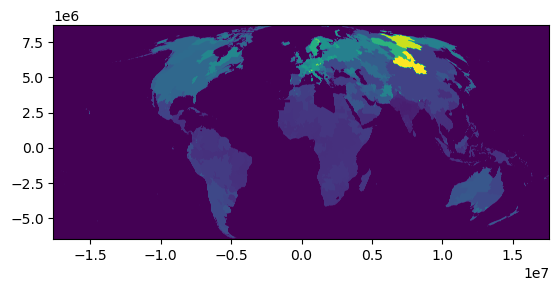

<Axes: >

In [ ]:
# fp = r'/shared/data/building-emissions/data/processing_files_gdal/eui_res_level4_compressed.tif'
img = rasterio.open(os.path.join(processing_gdal_dir,'eui_res_finest.tif'))
show(img)
# import rioxarray
# rds = rioxarray.open_rasterio(os.path.join(processing_gdal_dir,'eui_nres_finest.tif'))
# rds.name = "data"
# df = rds.squeeze().to_dataframe().reset_index()

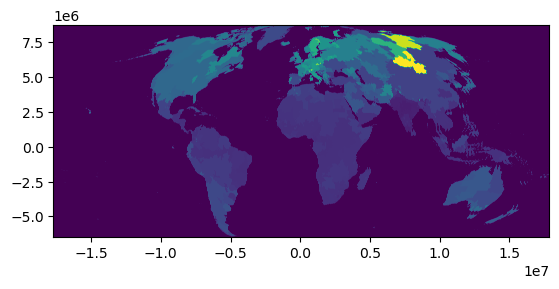

<Axes: >

In [ ]:
img = rasterio.open(os.path.join(processing_gdal_dir,'eui_res_finest_1.tif'))
show(img)

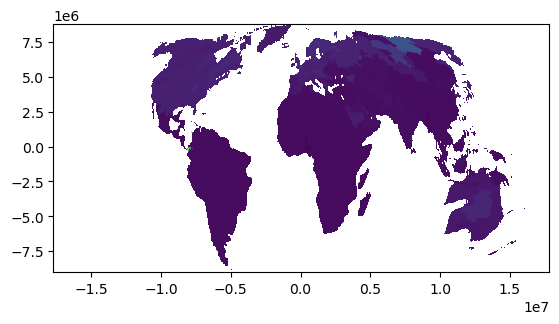

<Axes: >

In [ ]:
img = rasterio.open(os.path.join(processing_gdal_dir,'eui_nres_finest_correct.tif'))
show(img)

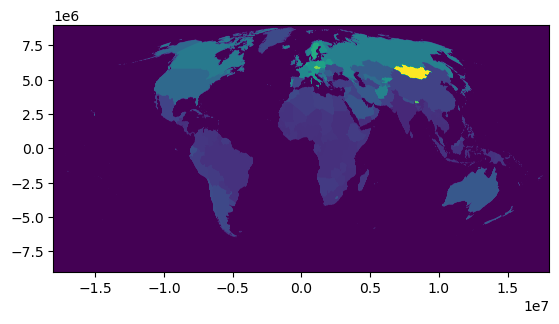

<Axes: >

In [11]:
img = rasterio.open(os.path.join(processing_gdal_dir,'eui_res_level2.tif'))
show(img)

In [1]:
import rioxarray


In [4]:
rds = rioxarray.open_rasterio(os.path.join(processing_gdal_dir,'res_co2_correct_compressed.tif'))
rds.name = "data"
df = rds.squeeze().to_dataframe().reset_index()
# replace the maximum value with 0
df_ = df[df['data']!= df.max().max()]

In [5]:
# replace the maximum value with 0
df_ = df[df['data']!= df.max().max()]

In [13]:
df_[df_.data < 1].data.sum()

1722063.615855631

In [16]:
# gdal
df_.data.sum()

3036473608.3985515

In [14]:
df_[df_.data < 1].data.sum()/ df_.data.sum()

0.0005671261594675458

In [8]:
df_[(df_.y == 3072500.0) &	(df_.x == 10306500.0)]

,y,x,band,spatial_ref,data


For residation co2 with Float 64, EF(mton/MJ), EUI(MJ/m2)
- MAX: 1.941307e+04
Most value is under 100(see the following plots)

In [21]:
df_[df_.data>100].count()

y              4558980
x              4558980
band           4558980
spatial_ref    4558980
data           4558980
dtype: int64

<Axes: >

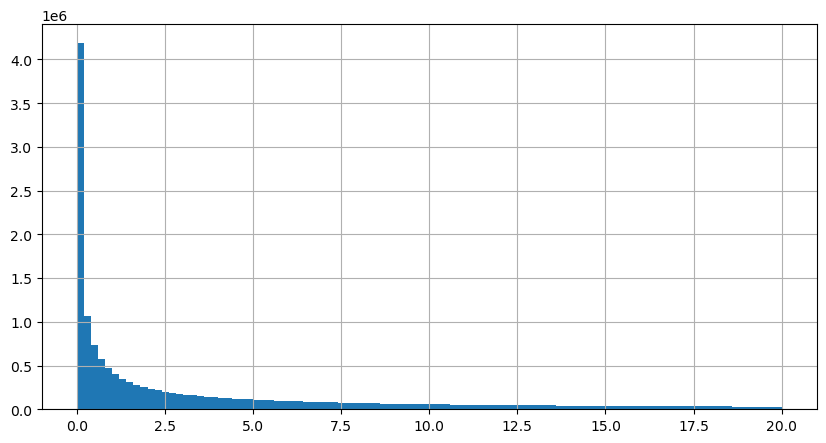

In [11]:
plt.figure(figsize=(10, 5))
df_[(df_.data<20) & (df_.data != 0)].data.hist(bins = 100)

In [ ]:
# get the third min value
sortx = df[df['data']!=0].sort_values(by='data', ascending=True)


In [ ]:
sortx[(sortx['data']!=4294967293) & (sortx['data']!=0)]

,y,x,band,spatial_ref,data
271327792,1.336150e+06,9.125432e+06,1,0,263
250869400,1.895193e+06,9.225909e+06,1,0,263
253070424,1.835049e+06,9.247581e+06,1,0,263
344857234,-6.732484e+05,3.536113e+06,1,0,362
343342000,-6.318378e+05,3.742979e+06,1,0,362
...,...,...,...,...,...
284516703,9.752869e+05,-7.720345e+06,1,0,1665959680
283073388,1.014726e+06,-7.754823e+06,1,0,1704084480
280402911,1.087687e+06,-8.157719e+06,1,0,1830841600
283109473,1.013740e+06,-7.751868e+06,1,0,1939418880


In [ ]:
df[(df['data']!=4294967293) & (df['data']!=0)]

,y,x,band,spatial_ref,data
33968661,7.821835e+06,-2.434430e+06,1,0,504538
34870700,7.797186e+06,-2.445266e+06,1,0,898572
35015032,7.793242e+06,-2.441325e+06,1,0,58160
35303662,7.785354e+06,-2.466937e+06,1,0,234094
35772739,7.772537e+06,-2.456102e+06,1,0,90148
...,...,...,...,...,...
554593479,-6.404669e+06,-4.759208e+06,1,0,49664
554773901,-6.409599e+06,-4.747387e+06,1,0,102044
554809980,-6.410585e+06,-4.750343e+06,1,0,168780
555170786,-6.420445e+06,-4.764134e+06,1,0,2751


In [ ]:
rds = rioxarray.open_rasterio(os.path.join(processing_gdal_dir,'eui_area_nres.tif'))
rds.name = "data"
df = rds.squeeze().to_dataframe().reset_index()
df.max().max()

In [ ]:
# get the second largest value
df = df.sort_values(by=['data'], ascending=False)
df.iloc[1,2]

## Kyle's

In [13]:
# COMPRESS AN IMAGE
data_path = 'co2_total_20yr.tif'
out_path = 'compress_test.tif'
compress(data_path,out_path)

In [14]:
# CREATE EMPTY GRID EXAMPLE
source_path = 'ghs.tif'
dest_path = 'grid.tif'
create_empty_grid(source_path,dest_path,0)

rows = 36082 columns = 18000
Band Type =  4
rows = 36082 columns = 18000
Band Type =  4


In [15]:
# RASTERIZE A VECTOR DATASET
attribute = "pop_est"
layername = "world"
vector_file_path = "world.json"
raster_grid_path = "grid.tif"
rasterize(attribute,layername,vector_file_path,raster_grid_path)

0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
# Create two files to multiply together
source_path = 'grid.tif'
dest_path1 = 'grid1.tif'
dest_path2 = 'grid2.tif'
create_empty_grid(source_path,dest_path1,2)
create_empty_grid(source_path,dest_path2,3)

rows = 36082 columns = 18000
Band Type =  4
rows = 36082 columns = 18000
Band Type =  4
rows = 36082 columns = 18000
Band Type =  4
rows = 36082 columns = 18000
Band Type =  4


In [17]:
# EXAMPLE OF HOW TO MULTIPLY BANDS TOGETHER
mult1_path = "grid.tif"
mult2_path = "grid1.tif"
mult3_path = "grid2.tif"
file_list = [mult1_path,mult2_path,mult3_path]
out_file = 'new_result.tif'
multiply_single_band_files(file_list,out_file)

0...10...20...30...40...50...60...70...80...90...100 - done.


### change crs and save as geojson file(this part of is not used eventually)

ESRI 54009   
`+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs`

Erros after saving as JSON file (level3 and level 4)

In [ ]:
# # from pyproj import CRS
# # crs = CRS.from_string('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs')
# def change_crs(input_file, output_file, crs):
#     df = gpd.read_parquet(input_file)
#     nds = df.to_crs(crs)
#     nds.to_file(output_file, driver="GeoJSON")

In [ ]:
# eui_4_gdf_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level4_simplified.parquet'
# eui_4_json_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level4_simplified.json'
# eui_3_gdf_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level3_simplified.parquet'
# eui_3_json_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level3_simplified.json'
# eui_2_gdf_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level2_simplified.parquet'
# eui_2_json_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level2_simplified.json'
# eui_1_gdf_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level1_simplified.parquet'
# eui_1_json_path = '/shared/data/building-emissions/data/processing_files_gdal/eui_level1_simplified.json'
# # merged_eui_ef_gdf_path = '/shared/data/building-emissions/data/processing_files_gdal/merged_eui_ef_simplified.parquet'
# # merged_eui_ef_json_path = '/shared/data/building-emissions/data/processing_files_gdal/merged_eui_ef_simplified.json'

# change_crs(eui_4_gdf_path, eui_4_json_path, 'ESRI:54009')
# change_crs(eui_3_gdf_path, eui_3_json_path, 'ESRI:54009')
# change_crs(eui_2_gdf_path, eui_2_json_path, 'ESRI:54009')
# change_crs(eui_1_gdf_path, eui_1_json_path, 'ESRI:54009')

# ef_gdf_path = '/shared/data/building-emissions/data/emissionsfactors/global_emissionsfactors_nobiofuel_simplified.parquet'
# ef_json_path = '/shared/data/building-emissions/data/processing_files_gdal/ef_simplified.json'

# change_crs(ef_gdf_path, ef_json_path, 'ESRI:54009')


In [ ]:
# gdal_rasterize -a Residential_Methane -l ef_simplified /home/yh354/ef_simplified.json /home/yh354/ef_res_methane_esri.tif